# Gerênciamento de Dependências

As instalações de dependências e seus imports.

In [1]:
# Upgrade do pip
!pip install --upgrade pip

# Instalação dos pacotes
!pip install gdown # Serve pra baixar arquivos do google drive
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install missingno
!pip install matplotlib
!pip install scikit-learn
!pip install xgboost

!pip install scikeras

In [2]:
# Import dos Pacotes
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MultiLabelBinarizer, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency
from xgboost import XGBClassifier

import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

# Download do Dataset

Puxar o dataset do google drive

In [3]:
!gdown 1ISRC99c1SyDwpsWh5E8OjSMtxpd6ux22

Downloading...
From: https://drive.google.com/uc?id=1ISRC99c1SyDwpsWh5E8OjSMtxpd6ux22
To: /home/juliocoliveira/Julio/Github/faculdade_ia_machine-learning-and-n8n/sods.csv
100%|████████████████████████████████████████| 849k/849k [00:00<00:00, 2.30MB/s]


# Carregar Dataset

Carregar e passar para dataframe

In [4]:
# Carregar o dataset e ver algumas informações básicas
dataset = pd.read_csv("sods.csv") 
dataset

,idade,genero,etnia,pcd,vive_no_brasil,estado_moradia,nivel_ensino,formacao,tempo_experiencia_dados,linguagens_preferidas,bancos_de_dados,cloud_preferida,cargo
0,39.0,Masculino,Parda,Não,True,Distrito Federal (DF),Pós-graduação,Computação / Engenharia de Software / Sistemas...,de 1 a 2 anos,R,"PostgreSQL, Oracle, MySQL, SQL SERVER",Amazon Web Services (AWS),DBA/Administrador de Banco de Dados
1,32.0,Masculino,Parda,Não,True,Pará (PA),Graduação/Bacharelado,Outras Engenharias,de 3 a 4 anos,NaN,NaN,NaN,NaN
2,53.0,Masculino,Branca,Não,True,Distrito Federal (DF),Pós-graduação,Computação / Engenharia de Software / Sistemas...,de 3 a 4 anos,Python,"PostgreSQL, MySQL, Oracle, DB2",Amazon Web Services (AWS),Desenvolvedor/ Engenheiro de Software/ Analist...
3,27.0,Masculino,Branca,Não,True,Minas Gerais (MG),Doutorado ou Phd,Estatística/ Matemática / Matemática Computaci...,de 4 a 6 anos,Python,Google BigQuery,Não sei opinar,Cientista de Dados/Data Scientist
4,46.0,Feminino,Branca,Não,True,Pará (PA),Pós-graduação,Computação / Engenharia de Software / Sistemas...,Não tenho experiência na área de dados,Python,Microsoft Access,Amazon Web Services (AWS),Desenvolvedor/ Engenheiro de Software/ Analist...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4266,26.0,Masculino,Branca,Não,True,São Paulo (SP),Graduação/Bacharelado,Computação / Engenharia de Software / Sistemas...,de 3 a 4 anos,Python,"PostgreSQL, Oracle, MariaDB, HBase, MySQL",Não sei opinar,Analista de Dados/Data Analyst
4267,30.0,Feminino,Branca,Não,True,Minas Gerais (MG),Mestrado,Outras Engenharias,de 1 a 2 anos,Python,"SQL SERVER, SAP HANA",Azure (Microsoft),Engenheiro de Dados/Arquiteto de Dados/Data En...
4268,29.0,Masculino,Branca,Não,True,São Paulo (SP),Mestrado,Outras Engenharias,de 4 a 6 anos,NaN,NaN,NaN,NaN
4269,NaN,Masculino,Branca,Não,True,São Paulo (SP),Não tenho graduação formal,NaN,Menos de 1 ano,Python,"Microsoft Access, Oracle",Azure (Microsoft),Outra Opção


# Pré Processamento

Visualizar os dados e fazer alteração neles, conforme o necessário

### Definição da seed, para reprodutibilidade.

In [5]:
RANDOM_STATE = 42

### Funções Auxiliares

In [6]:
def show_missig_values(dataset):
    missing_counts = dataset.isnull().sum().reset_index()
    missing_counts.columns = ["coluna", "valores_faltantes"]
    
    print("Número de valores faltando.")
    for col, val in dataset.isnull().sum().items():
        print(f"{col}: {val} -> {val/4271*100:.2f}%")
    
    plt.figure(figsize=(12,6))
    sns.barplot(data=missing_counts, 
                x="coluna", 
                y="valores_faltantes",
                hue="coluna",
                palette="viridis",
                legend=False,
                dodge=False)
    
    plt.xticks(rotation=45, ha='right')
    plt.title("Valores Faltando por Coluna", fontsize=16)
    plt.xlabel("Colunas")
    plt.ylabel("Número de valores faltantando")
    plt.tight_layout()
    plt.show()

def cramers_v_corrected(x, y):
    """Associação categórico↔categórico"""
    conf = pd.crosstab(x, y)
    if conf.size == 0:
        return np.nan
    chi2 = chi2_contingency(conf)[0]
    n = conf.to_numpy().sum()
    if n == 0:
        return np.nan
    phi2 = chi2 / n
    r, k = conf.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1)) if n > 1 else 0
    rcorr = r - ((r - 1)**2) / (n - 1) if n > 1 else r
    kcorr = k - ((k - 1)**2) / (n - 1) if n > 1 else k
    denom = min((kcorr - 1), (rcorr - 1))
    return np.sqrt(phi2corr / denom) if denom > 0 else 0.0

def correlation_ratio(categories, measurements):
    """Associação numérico↔categórico"""
    mask = (~pd.isna(categories)) & (~pd.isna(measurements))
    if mask.sum() == 0:
        return np.nan
    categories = pd.Series(categories[mask], dtype="category")
    measurements = measurements[mask]
    overall_mean = measurements.mean()
    means = measurements.groupby(categories, observed=False).mean()
    counts = measurements.groupby(categories, observed=False).count()
    ss_between = (counts * (means - overall_mean)**2).sum()
    ss_total = ((measurements - overall_mean)**2).sum()
    return float(np.sqrt(ss_between / ss_total)) if ss_total != 0 else 0.0

def calculate_association_strength(dataset, target, figsize):
    associacoes = []

    for col in dataset.columns:
        if col == target:
            continue
        if pd.api.types.is_numeric_dtype(dataset[col]) and col != "vive_no_brasil":
            # numérico × categórico
            assoc = correlation_ratio(dataset[target], dataset[col])
        else:
            # categórico × categórico
            assoc = cramers_v_corrected(dataset[target], dataset[col])
        associacoes.append({"coluna": col, "associacao": assoc})
    
    assoc_df = pd.DataFrame(associacoes).sort_values(by="associacao", ascending=False)
    
    # ----- Plot -----
    plt.figure(figsize=figsize)
    sns.barplot(data=assoc_df,
                x="associacao", 
                y="coluna", 
                hue="associacao",
                palette="viridis",
                legend=False,
                dodge=False)
    plt.title(f"Força de associação de cada coluna com '{target}'", fontsize=14)
    plt.xlabel("Força de Associação (0 a 1)")
    plt.ylabel("Coluna")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

def calculate_association_strength_text(dataset, target, number_of_prints):
    associacoes = []

    for col in dataset.columns:
        if col == target:
            continue
        if pd.api.types.is_numeric_dtype(dataset[col]) and col != "vive_no_brasil":
            # numérico × categórico
            assoc = correlation_ratio(dataset[target], dataset[col])
        else:
            # categórico × categórico
            assoc = cramers_v_corrected(dataset[target], dataset[col])
        associacoes.append({"coluna": col, "associacao": assoc})
    
    assoc_df = pd.DataFrame(associacoes).sort_values(by="associacao", ascending=False)

    print(assoc_df.head(number_of_prints))
    

def show_distribution(dataset, cut_columns=[]):
    for col in dataset.columns:
        if col in cut_columns:
            continue
        
        plt.figure(figsize=(8, 4))
        plt.title(f"Distribuição da coluna '{col}'", fontsize=14)
    
        if col == "idade":
            sns.histplot(dataset[col], 
                 color="skyblue", 
                 bins=50, 
                 stat="density")
    
            sns.kdeplot(dataset[col], 
                        color="red", 
                        linewidth=2)
            
            plt.xlabel(col)
            plt.ylabel("Frequência")
            plt.show()
    
        else:
            # Coluna categórica: barras de frequência
            sns.countplot(data=dataset,
                          x=col,
                          order=dataset[col].value_counts().index, 
                          palette="viridis",
                          hue=col,
                          legend=False,
                          dodge=False)
            plt.xticks(rotation=45, ha="right")
            plt.xlabel(col)
            plt.ylabel("Frequência")
            plt.show()

def group_by_synonyms(dataset, synonyms):
    copy = dataset.copy()
    
    for padrao, cols in synonyms.items():
        # Pega só as colunas que realmente existem no dataset
        cols_existentes = [c for c in cols if c in copy.columns]
        if not cols_existentes:
            continue
    
        # Cria a coluna mesclada
        copy[padrao] = copy[cols_existentes].max(axis=1)
    
        # Remove duplicadas
        copy = copy.drop(columns=cols_existentes)

    return copy

def cut_columns_by_threhsold(dataset, threshold):
    copy = dataset.copy()
    
    associacoes = []

    for col in copy.columns:
        if col == target:
            continue
        if pd.api.types.is_numeric_dtype(copy[col]) and col != "vive_no_brasil":
            # numérico × categórico
            assoc = correlation_ratio(copy[target], copy[col])
        else:
            # categórico × categórico
            assoc = cramers_v_corrected(copy[target], copy[col])
        associacoes.append({"coluna": col, "associacao": assoc})
    
    for row in associacoes:
        if row["associacao"] < threshold:
            copy = copy.drop(columns=row["coluna"])
        
    return copy

def classifier_columns(dataset):
    numeric_columns = []
    binary_columns = []
    categoric_columns = []

    for column in dataset.columns:
        unique_values = dataset[column].dropna().unique()
        number_of_unique_values = len(unique_values)
        
        if column == "idade":
            numeric_columns.append(column)

        elif number_of_unique_values == 2:
            binary_columns.append(column)

        else:
            categoric_columns.append(column)

    return {
        "numeric": numeric_columns,
        "binary": binary_columns,
        "categoric": categoric_columns
    }

def apply_map(dataset, target, target_map):
    copy = dataset.copy()
    copy.loc[:, target] = copy[target].replace(target_map)
    return copy

def evaluate_models(models, dataset, test_size, RANDOM_STATE=None, figsize=(8,6)):
    cms = {}
    
    y = dataset[target]
    X = dataset.drop(columns=[target])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size,  
        random_state=RANDOM_STATE  
    )

    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
        print(f"\n=== {name} ===")
        print("Accuracy :", accuracy_score(y_test, y_pred))
        print("Precision:", precision_score(y_test, y_pred, average="weighted", zero_division=0))
        print("F1-Score :", f1_score(y_test, y_pred, average="weighted"))
        print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))
    
        # --- Matriz de Confusão ---
        cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(le.classes_)))
        cms[name] = (cm, le.classes_)
        
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=le.classes_
        )
        fig, ax = plt.subplots(figsize=figsize)
        disp.plot(ax=ax,
                  cmap=plt.cm.Blues,
                 )
        ax.set_title(f"Matriz de Confusão - {name}")
        plt.xticks(rotation=45, ha="right")  # já está usando
        plt.yticks(rotation=0)               # deixa legível na vertical

        plt.show()

    return cms

def group_by_proximity(dataset, target, number_of_clusters, preprocessor):
    copy = dataset.copy()

    y = copy[target]
    X = copy.drop(columns=[target])

    X = preprocessor.fit_transform(X)

    copy = pd.DataFrame(X, columns=preprocessor.get_feature_names_out())

    copy[target] = y
     
    class_means = copy.groupby(target).mean()

    scaler = StandardScaler()
    class_means_scaled = scaler.fit_transform(class_means)
    
    Z = sch.linkage(class_means_scaled, method='ward')
    
    clusters = fcluster(Z, number_of_clusters, criterion='maxclust')
    
    cluster_dict = {}
    for classe, cluster_id in zip(class_means.index, clusters):
        cluster_dict.setdefault(cluster_id, []).append(classe)
        
    cargo_map = {}
    for cluster_id, members in cluster_dict.items():
        cluster_name = f"Cluster {cluster_id}"
        for m in members:
            cargo_map[m] = cluster_name
        
        print(f"{cluster_name}: {members}")

    return cargo_map

def group_by_confusion(confusion_matriz_dict, number_of_clusters):
    confusion_matriz = confusion_matriz_dict[0]
    labels = confusion_matriz_dict[1]
    
    # Normalização linha a linha → probabilidade de confusão
    cm_normalized = confusion_matriz.astype("float") / confusion_matriz.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # evitar divisões por zero

    # Similaridade simétrica = média da confusão mútua
    similarity = (cm_normalized + cm_normalized.T) / 2.0

    # Distância = 1 - similaridade
    distance = 1 - similarity
    
    # Clustering hierárquico
    Z = sch.linkage(distance, method="ward")
    
    # Extrair clusters
    clusters = fcluster(Z, number_of_clusters, criterion="maxclust")
    
    cluster_dict = {}
    for classe, cluster_id in zip(labels, clusters):
        cluster_dict.setdefault(cluster_id, []).append(classe)
    
    cargo_map = {}
    for cluster_id, members in cluster_dict.items():
        cluster_name = f"Cluster {cluster_id}"
        for m in members:
            cargo_map[m] = cluster_name
        
        print(f"{cluster_name}: {members}")

    return cargo_map

### Visualização de Valores Ausentes

Número de valores faltando.
idade: 74 -> 1.73%
genero: 9 -> 0.21%
etnia: 0 -> 0.00%
pcd: 0 -> 0.00%
vive_no_brasil: 0 -> 0.00%
estado_moradia: 115 -> 2.69%
nivel_ensino: 0 -> 0.00%
formacao: 122 -> 2.86%
tempo_experiencia_dados: 577 -> 13.51%
linguagens_preferidas: 1292 -> 30.25%
bancos_de_dados: 1293 -> 30.27%
cloud_preferida: 1290 -> 30.20%
cargo: 1290 -> 30.20%


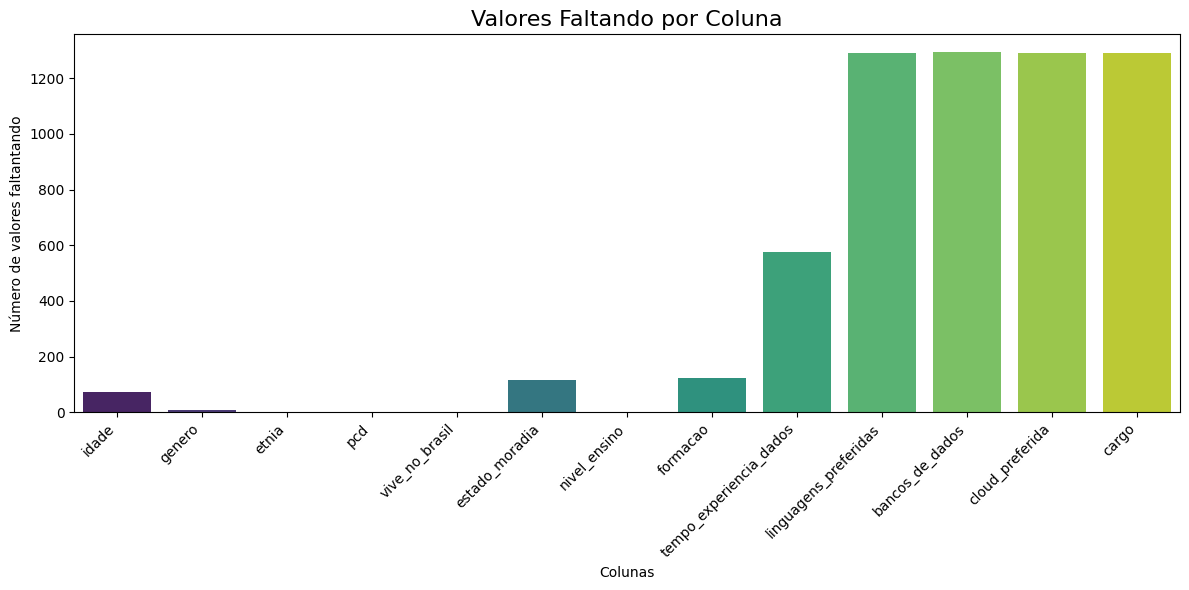

In [7]:
# Verificar o  número de valores ausentes nas tabelas.
show_missig_values(dataset)

### Tratamento da Coluna Cargo
A coluna cargo é o nosso target e, possui 30.2% de valores ausentes, com 1290 linhas ausentes. Como o dataset é pequeno, criar dados sinteticos não foi eficaz, sendo assim, optamos por eliminar as linhas com o cargo ausente.

In [8]:
target = "cargo"
dataset = dataset.dropna(subset=[target])

Número de valores faltando.
idade: 38 -> 0.89%
genero: 6 -> 0.14%
etnia: 0 -> 0.00%
pcd: 0 -> 0.00%
vive_no_brasil: 0 -> 0.00%
estado_moradia: 72 -> 1.69%
nivel_ensino: 0 -> 0.00%
formacao: 74 -> 1.73%
tempo_experiencia_dados: 0 -> 0.00%
linguagens_preferidas: 2 -> 0.05%
bancos_de_dados: 3 -> 0.07%
cloud_preferida: 0 -> 0.00%
cargo: 0 -> 0.00%


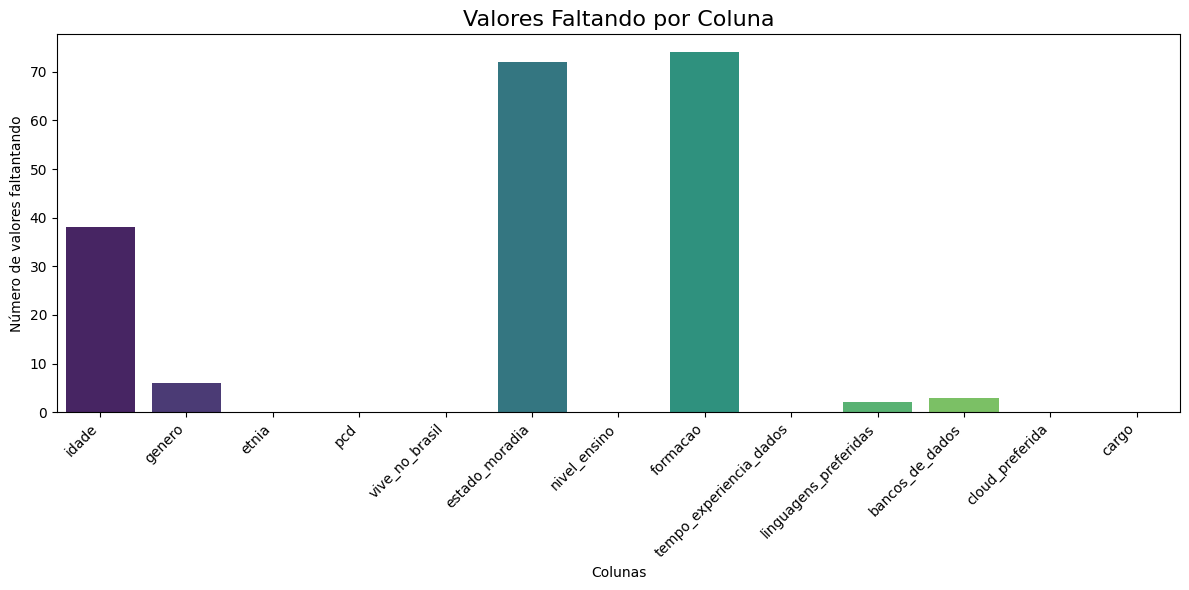

In [9]:
show_missig_values(dataset)

### Analisando a Força de Associação das Colunas com o Cargo
Banco de dados apresentou a menor associação, porém, isso ocorre devido ao modo como dataset foi registrado, sendo vários por linha. Para analisar corretamente é necessário isolar cada tipo em uma coluna diferente. Atualmente, essa coluna conta com 1473 categorias diferentes.

ERROR! Session/line number was not unique in database. History logging moved to new session 4


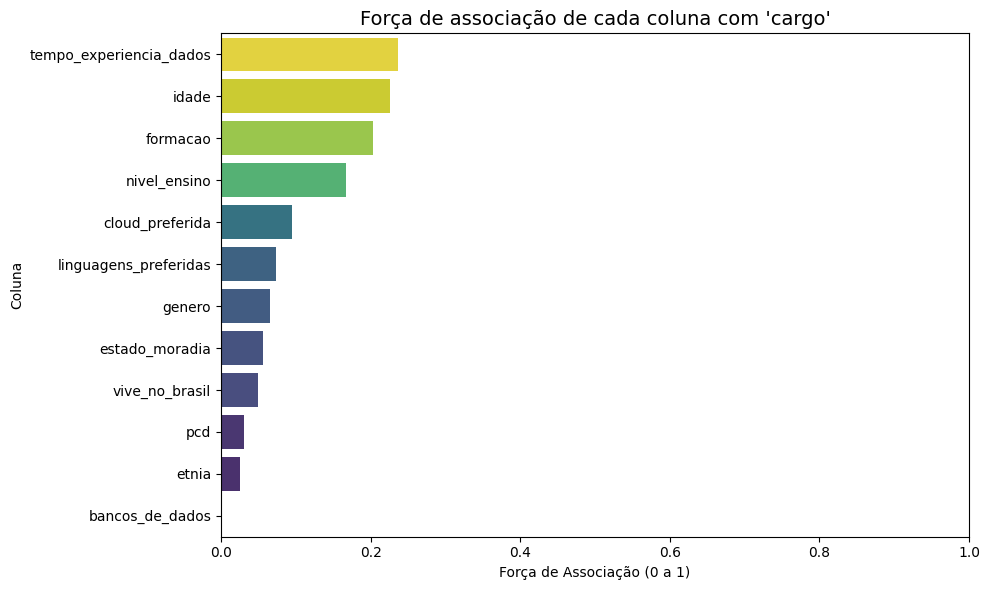

In [10]:
calculate_association_strength(dataset, target, (10,6))

In [11]:
calculate_association_strength_text(dataset, target, 12)

                     coluna  associacao
8   tempo_experiencia_dados    0.236526
0                     idade    0.226400
7                  formacao    0.202698
6              nivel_ensino    0.167161
11          cloud_preferida    0.095399
9     linguagens_preferidas    0.074134
1                    genero    0.065619
5            estado_moradia    0.056000
4            vive_no_brasil    0.050028
3                       pcd    0.030340
2                     etnia    0.025543
10          bancos_de_dados    0.000000


In [12]:
dataset["bancos_de_dados"].value_counts()

bancos_de_dados
Google BigQuery                                                                              227
SQL SERVER                                                                                   202
MySQL                                                                                        116
Databricks                                                                                    71
PostgreSQL                                                                                    69
                                                                                            ... 
Elaticsearch, SAP HANA, Oracle, MySQL                                                          1
Amazon Athena, MySQL, PostgreSQL, S3, Databricks                                               1
SQL SERVER, MySQL, Google BigQuery, PostgreSQL                                                 1
MySQL, Hive, Databricks, PostgreSQL, Splunk, S3, Presto, Amazon Redshift, Google BigQuery      1
Não trabalho c

### Analisando as Categorias de Cada Coluna e sua Distribuição
Visualizando todos, exceto a coluna bancos de dados. Já que, por possuir muitas categorias, exibir em um gráfico não é eficaz.

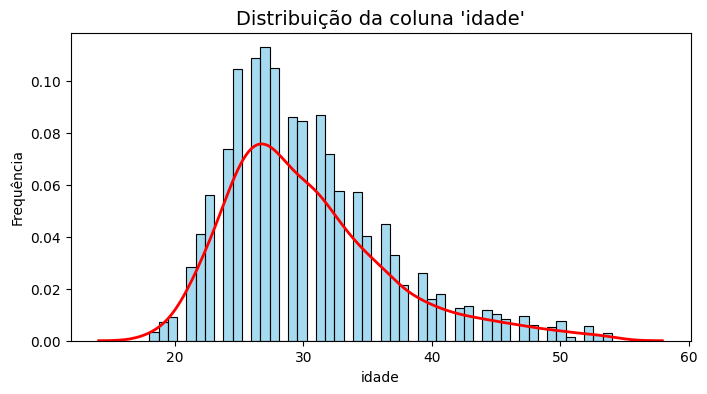

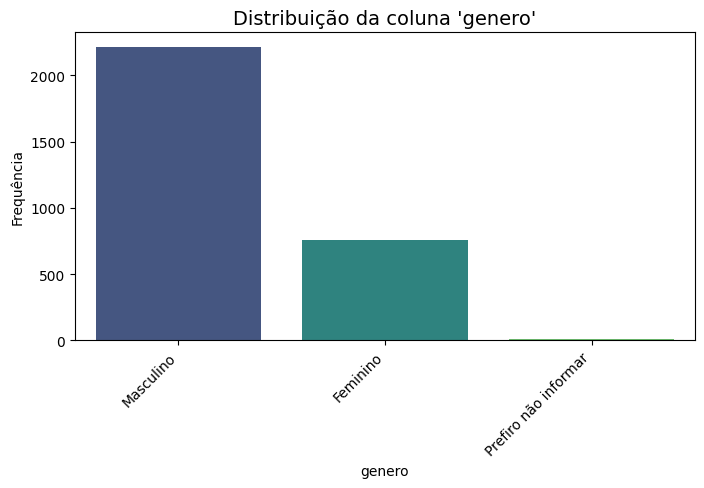

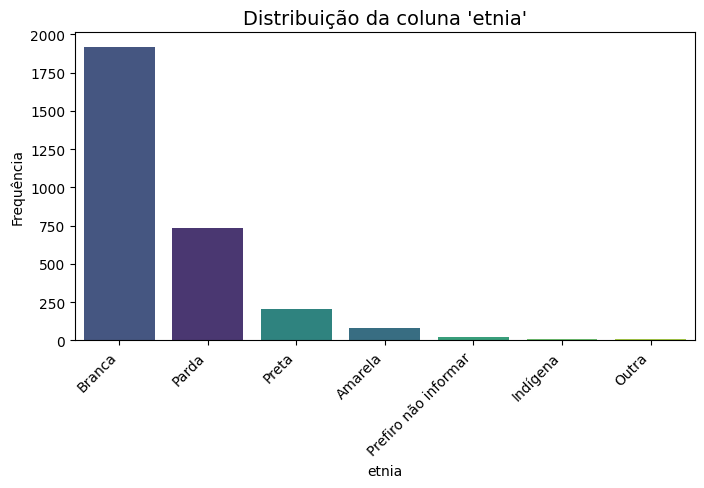

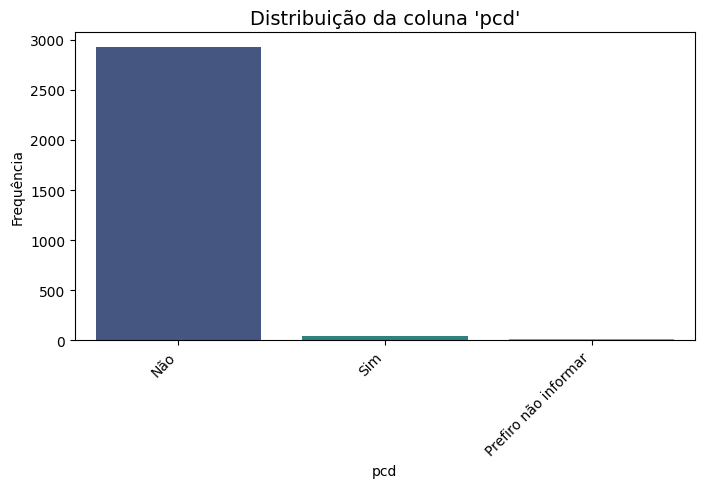

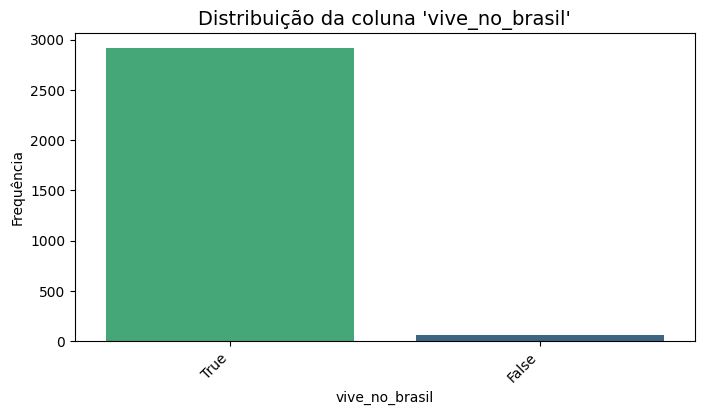

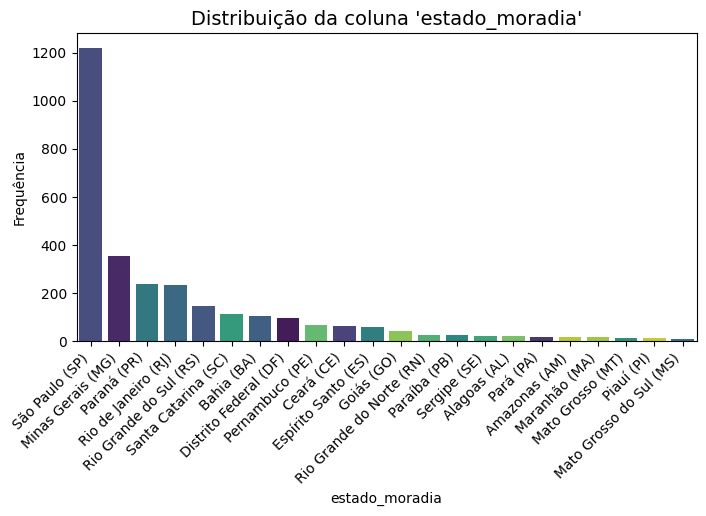

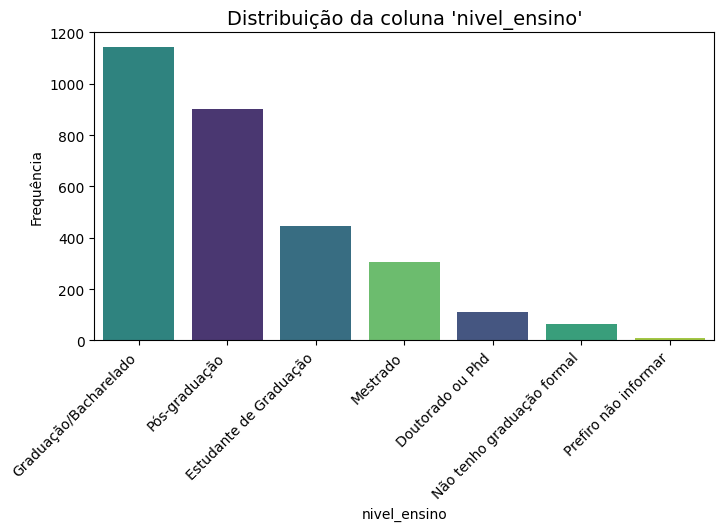

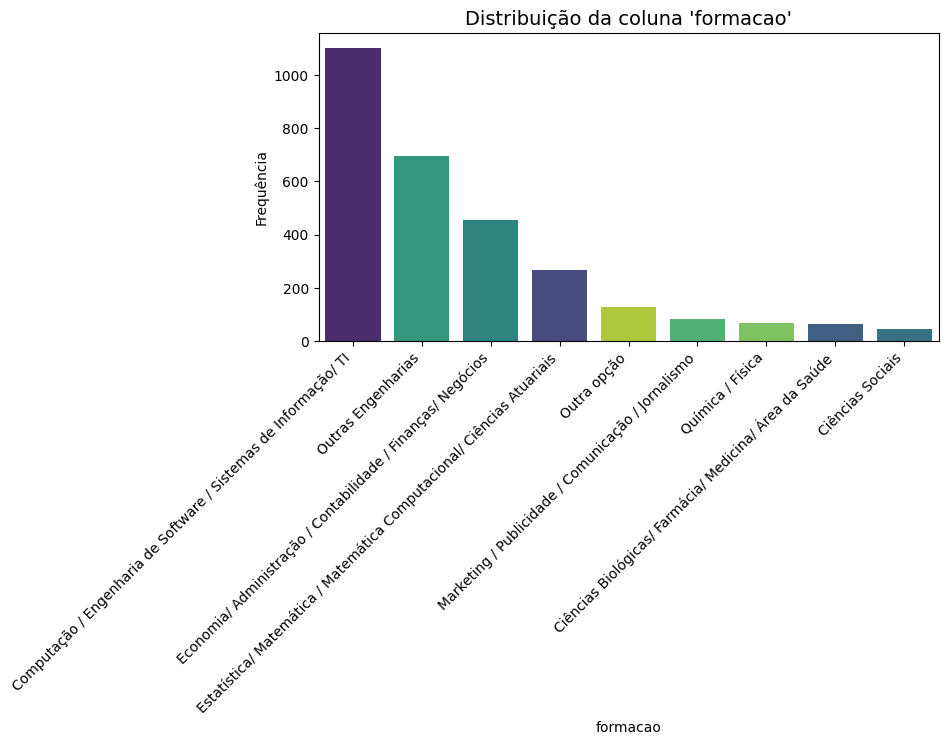

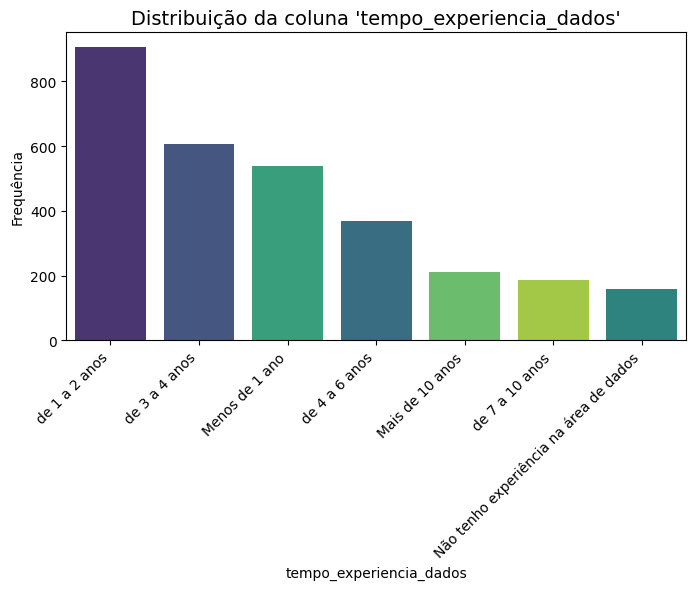

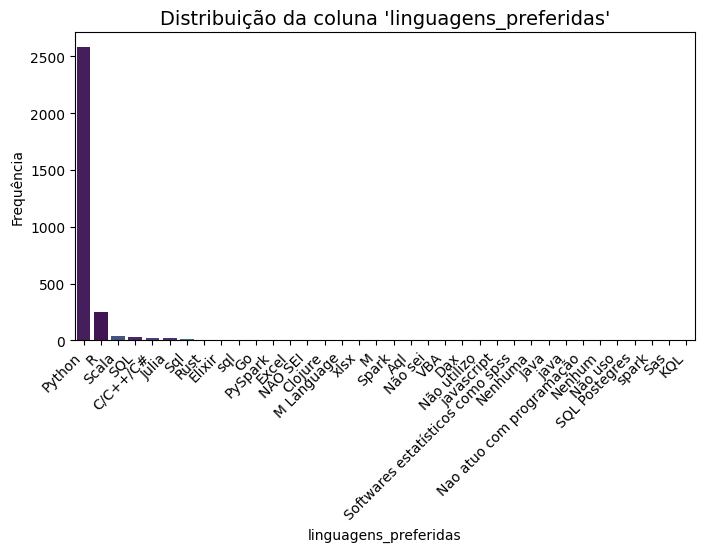

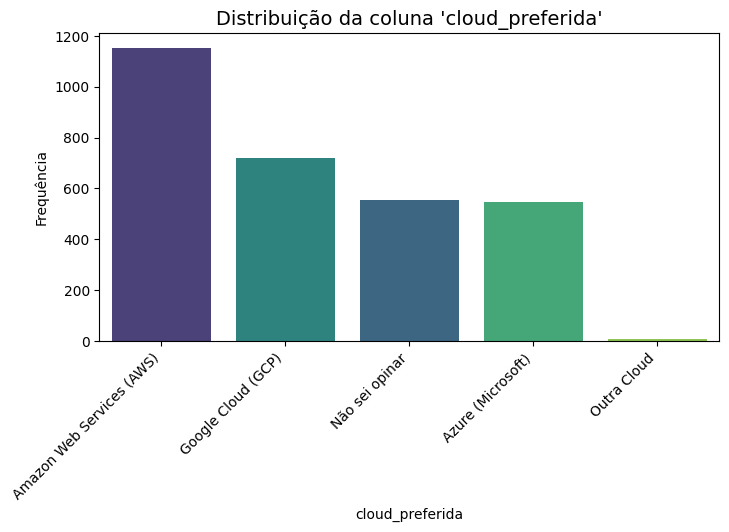

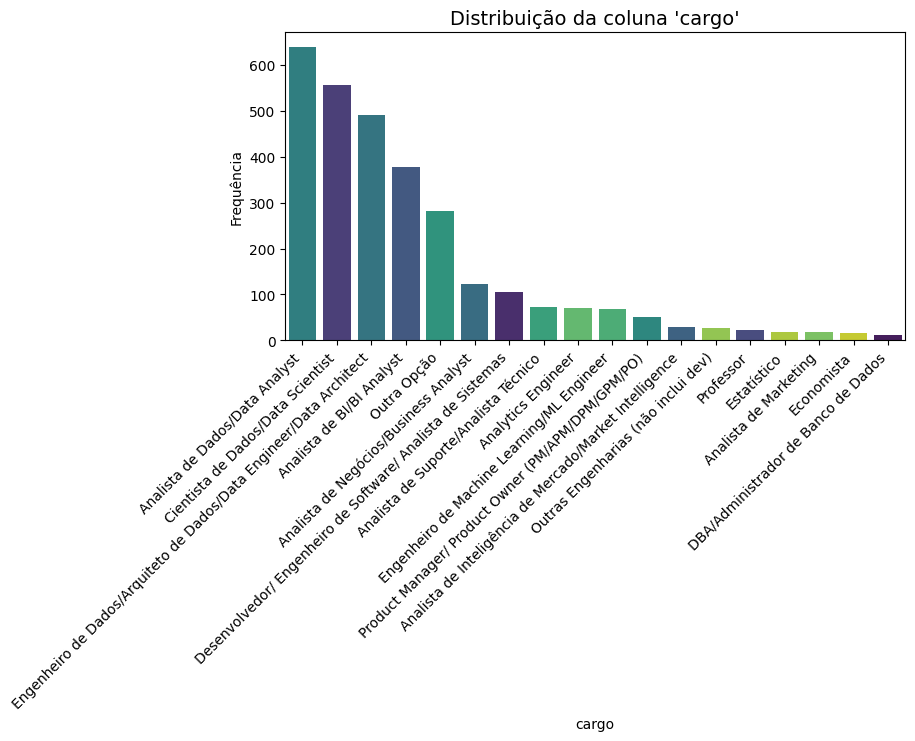

In [13]:
show_distribution(dataset, ["bancos_de_dados"])

### Isolando os Valores da Coluna Banco de Dados

In [14]:
dataset_isoleted_BDs = dataset.copy()

dataset_isoleted_BDs['bancos_list'] = dataset_isoleted_BDs['bancos_de_dados'].str.split(r',\s*')
dataset_isoleted_BDs['bancos_list'] = dataset_isoleted_BDs['bancos_list'].apply(lambda x: x if isinstance(x, list) else [])

mlb = MultiLabelBinarizer()
dataset_isoleted_BDs_e = mlb.fit_transform(dataset_isoleted_BDs['bancos_list'])

bancos_df = pd.DataFrame(dataset_isoleted_BDs_e, columns=mlb.classes_, index=dataset.index)

dataset_isoleted_BDs = dataset_isoleted_BDs.drop(columns='bancos_de_dados')
dataset_isoleted_BDs = pd.concat([dataset_isoleted_BDs, bancos_df], axis=1)
dataset_isoleted_BDs = dataset_isoleted_BDs.drop(columns='bancos_list')

In [15]:
dataset_isoleted_BDs.shape

(2981, 202)

### Unindo Sinônimos
Ao isolar os valores da coluna banco de dados, vários sinônimos surgiram. Agrupamos primeiramente por sinonimos diretos, e logo após por semântica.

Mais ou menos 50 coluna foram reduzidas.

In [16]:
synonyms = {
    "Nenhum": [
        "NENHUM", "Nao uso", "Nao utilizo", "Nd", "Nda", "Nenhum", 
        "Nenhum acima", "Nenhum desses", "Nenhum destes", "Nenhum dos citados acima", 
        "Nenhum dos listados", "Nenhuma", "Nenhuma das respostas", "NÃO RECONHEÇO NENHUM", 
        "Não Utilizo nenhum", "Não atuo ainda nisso", "Não atuo na área ainda", 
        "Não possuímos um banco de dados.", "Não se aplica", "Não sei", "Não temos BD", 
        "Não tenho acesso ao banco de dados devido ao compliance da empresa", 
        "Não trabalho com banco diretamente", "Não trabalho com base de dados.", 
        "Não trabalho com dados", "Não usamos", "Não uso", "Não uso BD no trabalho", 
        "Não utilizo", "Não utilizo bancos de dados.", "Não utilizo nenhum", 
        "Não utilizo.", "Não utiluzo", "nao utilizo", "nenhum", "nenhuma", 
        "não sei", "não uso nenhum", "não utilizamos banco de dados", "Nao atuo na area de tech na empresa ainda",
        "Nao uso", "Nao utilizo", "Nda", "Nenhum", "Nenhuma", "Não trabalho com dados",
        "Não usamos", "Não uso", "Não utilizo", "não uso nenhum", "não utilizamos banco de dados"
    ],
    "Excel": [
        "EXCEL", "Excel", "apenas Excel", "nosso banco é no excel", "excel",
        "Bases Excel e csv extraídas direto no site", "Office", "Fontes da empresa em html ou csv"
    ],
    "Google BigQuery": [
        "BigQuery", "Google BigQuery", "Google Big Query", "Google BigQuery"
    ],
    "SQL Server": [
        "MSSQL", "SQL SERVER", "SQL Dbx"
    ],
    "Azure Blob Storage": [
        "Azue Blob Storage", "Azure Blob Storage", "Azure blob storage"
    ],
    "Google Sheets": [
        "Google Sheets", "Google sheets"
    ],
    "Bigtable": [
        "BigTable", "Bigtable", "big table"
    ],
    "Clickhouse": [
        "ClickHouse", "Clickhouse"
    ],
    "Azure Data Lake": [
        "Azure Data Lake", "Azure Data lake", "Azure ADLS", "Azure Data Lake"
    ],
    "Dados internos": [
        "Base de dados local", "Base interna", "Dados internos", "interno", "internos",
        "Fontes internas e de clientes", "Solução proprietária", "Banco de dados próprio da empresa"
    ],
    "Não aplicável": [
        "estou em transição de carreira", "somente em cursos", "não trabalho com dados",
        "Não trabalho com base de dados.", "Não trabalho com dados"
    ]
}

groups = {
    "Estatística": ["SPSS", "SAS", "SAS Libs", "sas", "Sintax"],

    "Amazon BD": ["Amazon Athena", "Amazon Aurora ou RDS", "Amazon Redshift"],
    "Amazon Storage": ["S3"],

    "Azure BD": ["Azure SQL", "Azure Data Explorer", "Azure Synapse"],
    "Azure Storage": ["Azure Storage Account"],
    "Azure Integração": ["Consumo de APIS com azure functions"],
    "Azure Geral": ["Azure", "MS Azure"],

    "Google BD": ["Cloud Spanner", "Google Firestore"],
    "Google Storage": ["Google Cloud Storage", "GCS"],
    "Google Geral": ["Google", "Google Cloud"],

    "IBM BD": ["DB2", "Informix", "IBM Informix"],
    "IBM Ferramentas": ["Cognos", "IBm blue mix"],

    "SAP BD": ["HANA", "SAP HANA"],
    "SAP ERP": ["SAP", "SAP ECC", "B.O SAP"],

    "Oracle BD": ["Oracle", "Autonomous DB"],

    "SQL BD": ["PostgreSQL", "MySQL", "MariaDB", "SQL Server", "SQLite", "Progress", "Sybase"],
    "Microsoft Access": ["Access", "Microsoft Access"],

    "NoSQL BD": ["MongoDB", "Cassandra", "CoachDB", "DynamoDB", "Neo4J", "Redis"],
    "Busca/Indexação": ["Elaticsearch", "Solr"],
    "Time Series": ["InfluxDB"],
    "Firebase": ["Firebase"],

    ### Big Data / Data Lake
    "Hadoop": ["Hadoop", "Hive", "HUE"],
    "Databricks": ["Databricks", "Databricks SQL", "Deltalake"],
    "HPCC Systems": ["HPCC Systems", "Dali - HPCC System"],
    "Motores SQL Alternativos": ["Presto", "Dremio", "DuckDB", "CruxDB"],

    ### BI / Analytics
    "BI Tools": ["PowerBI", "MicroStrategy", "Cognos", "Metabase", "Knime", "Denodo"],
    "Splunk": ["Splunk"],

    ### CRM / ERP
    "CRM/ERP": ["Salesforce", "sistema de crm", "RD STATION", "Medidata Rave", "Espaider"],
    "SharePoint": ["SharePoint", "Sharepoint", "Lista do Sharepoint"],
    "Kobotoolbox": ["Kobotoolbox"],

    "Excel": ["Excel",".CSV"],
    "APIs": ["API", "PWA Microsoft - MySQL ou SQL"],
    
    "Dados Públicos/Externos": ["DATASUS", "Dados públicos externos",
                                "Diversas fontes de marketing digital",
                                "midias sociais",
                                "Pesquisas empírica que eu coleto os dados",
                                "Dados não estruturados",
                                "Dados geoespaciais"],

    "Dados internos": ["Dados internos", "Interno", "dados alternativos e dados internos da empresa"],
    "Ferramentas": ["DBeaver"],
    "Segurança": ["NSA"],
    "Outro/Não aplicável": ["Outro", "none", "Não aplicável"],
}

In [17]:
dataset_isoleted_BDs = group_by_synonyms(dataset_isoleted_BDs, synonyms)
dataset_isoleted_BDs = group_by_synonyms(dataset_isoleted_BDs, groups)

In [18]:
dataset_isoleted_BDs.shape

(2981, 62)

In [19]:
calculate_association_strength_text(dataset_isoleted_BDs, target, 60)

                      coluna  associacao
34            Amazon Storage    0.376804
48                  NoSQL BD    0.327076
33                 Amazon BD    0.303007
8    tempo_experiencia_dados    0.236526
59                 Segurança    0.228722
47                    SQL BD    0.227040
0                      idade    0.226400
7                   formacao    0.202698
49           Busca/Indexação    0.200740
46                 Oracle BD    0.181273
57            Dados internos    0.177481
51  Motores SQL Alternativos    0.169485
6               nivel_ensino    0.167161
25                 Snowflake    0.166266
15          Google Analytics    0.162619
56   Dados Públicos/Externos    0.159165
28                  Teradata    0.155735
32               Estatística    0.152169
14                  Firebird    0.150189
16                     HBase    0.138936
29                   Vertica    0.134302
13                   Datomic    0.122295
55                      APIs    0.114921
44              

### Eliminando as Colunas com Baixa Associação em um Dataset Separado

Foi uma das tentativas para melhorar o desempenho, porém não foi tão eficaz.
Alternamos para o agrupamento das labels, que se provou mais eficaz.

In [20]:
dataset_cut = cut_columns_by_threhsold(dataset_isoleted_BDs, 0.065)

In [21]:
dataset_isoleted_BDs.shape

(2981, 62)

In [22]:
dataset_cut.shape

(2981, 38)

### Visualizando a Associação Novamente

Já que novas colunas foram geradas, uma nova analise é necessária.

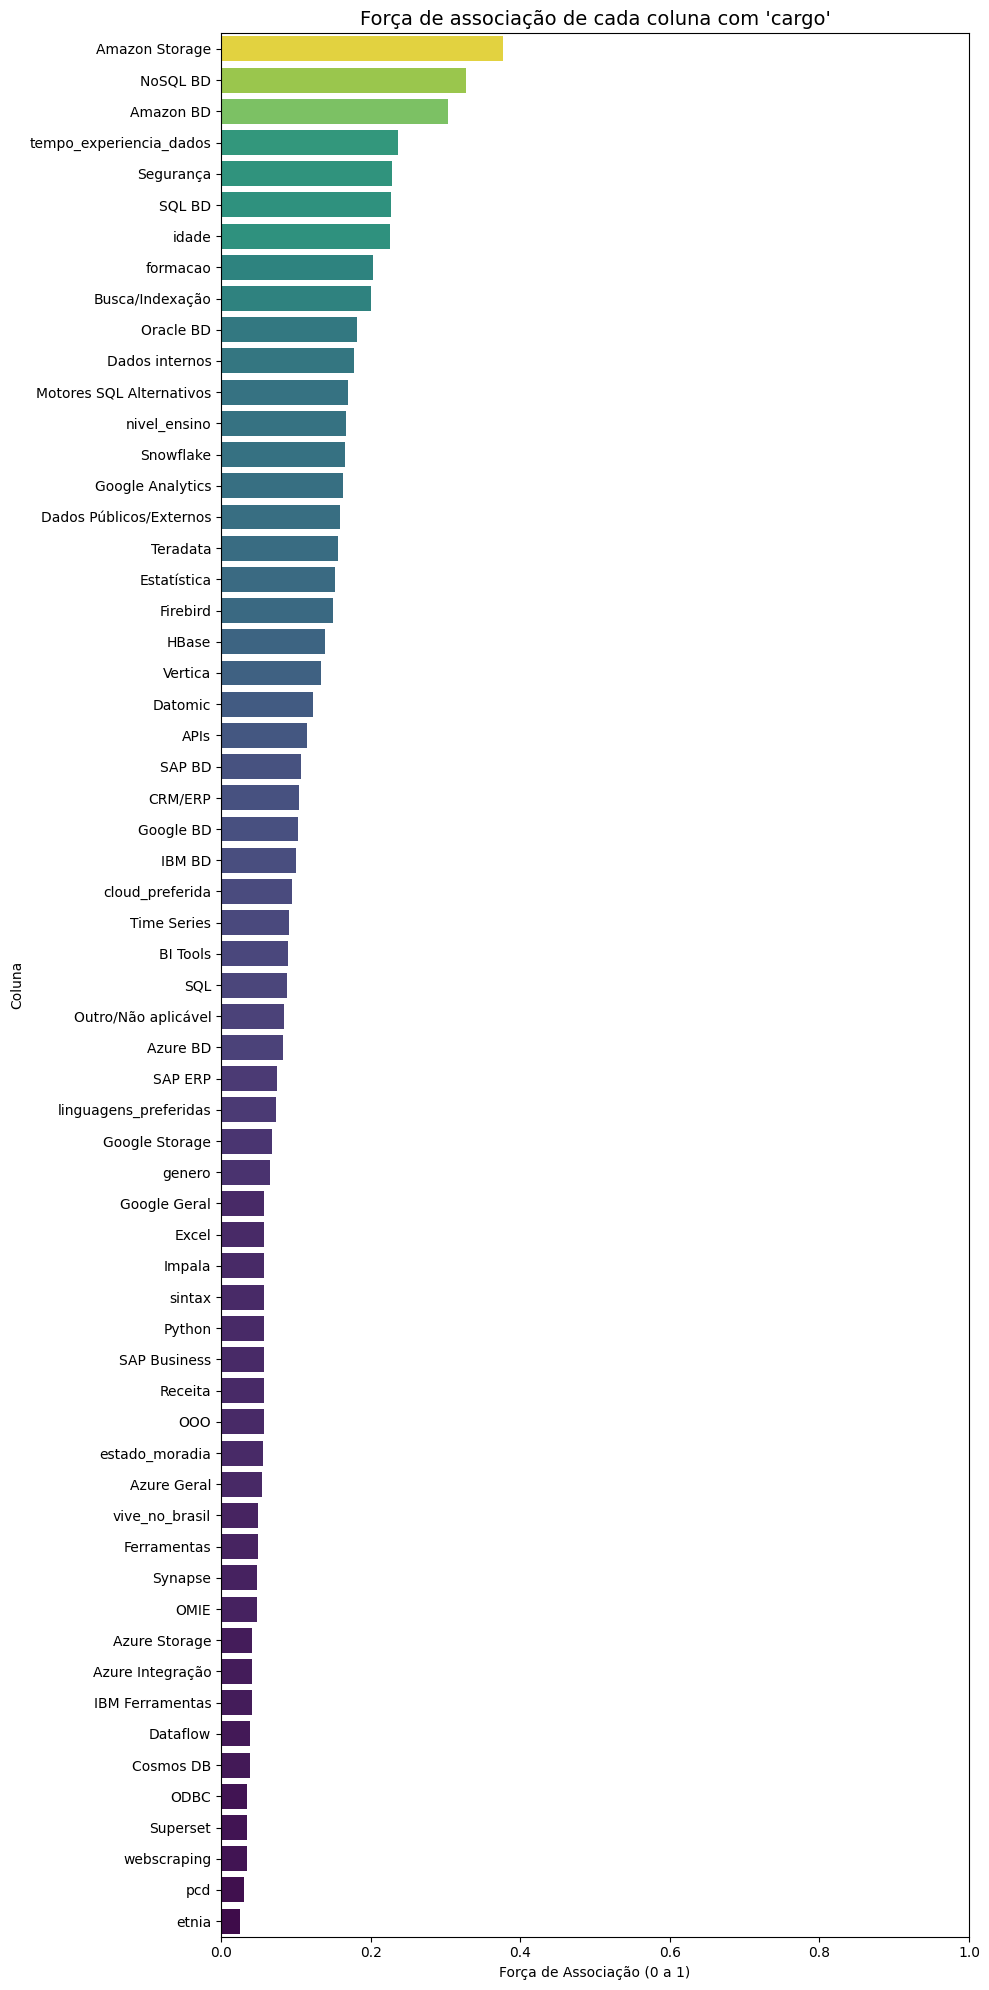

In [23]:
calculate_association_strength(dataset_isoleted_BDs, target, (10, 20))

### Teste para Avaliar a Predição Inicial

Testando para avaliar o desempenho incial do modelo, verificando quais classes estão sendo mais confudidas entre si.
Além disso, tratando os dados atráves de um pipeline, assim o tratamento já fica junto com o modelo.

In [24]:
initial_evaluate_dataset = dataset_isoleted_BDs

In [25]:
initial_evaluate_dataset[target].value_counts()

cargo
Analista de Dados/Data Analyst                                         639
Cientista de Dados/Data Scientist                                      556
Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect    490
Analista de BI/BI Analyst                                              378
Outra Opção                                                            281
Analista de Negócios/Business Analyst                                  123
Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas            106
Analista de Suporte/Analista Técnico                                    72
Analytics Engineer                                                      70
Engenheiro de Machine Learning/ML Engineer                              69
Product Manager/ Product Owner (PM/APM/DPM/GPM/PO)                      51
Analista de Inteligência de Mercado/Market Intelligence                 29
Outras Engenharias (não inclui dev)                                     28
Professor          

In [26]:
inital_types = classifier_columns(initial_evaluate_dataset.drop(columns=[target]))

In [27]:
initial_numeric_transformer = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5)), # Preenche os valores ausentes, atráves dos n vizinhos mais próximos.
    ("scaler", StandardScaler()) # Normaliza, média 0 e desvio padrão 1.
])

initial_binary_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")), # Preenche os valores ausentes, com a moda.
    ("encoder", OneHotEncoder(handle_unknown="ignore")) # Torna as colunas categoricas em binarias.
])

initial_categoric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")), # Preenche os valores ausentes, com a moda.
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)) # Passa pra 0 e 1.
])

initial_preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", initial_numeric_transformer, inital_types["numeric"]),
        ("binary", initial_binary_transformer, inital_types["binary"]),
        ("categoric", initial_categoric_transformer, inital_types["categoric"])
    ]
)

In [28]:
# Decision Tree
initial_tree_pipeline = Pipeline(steps=[
    ("preprocessor", initial_preprocessor),
    ("model", DecisionTreeClassifier(
        max_depth=6,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=RANDOM_STATE
    ))
])

# XGBoost
initial_xgb_pipeline = Pipeline(steps=[
    ("preprocessor", initial_preprocessor),
    ("model", XGBClassifier(
        n_estimators=170,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        eval_metric="mlogloss"
    ))
])


=== Decision Tree ===
Accuracy : 0.2949061662198391
Precision: 0.2327666008058691
F1-Score : 0.25399376823966696

Classification Report:
                                                                      precision    recall  f1-score   support

                                          Analista de BI/BI Analyst       0.12      0.09      0.10        82
                                     Analista de Dados/Data Analyst       0.24      0.50      0.32       149
            Analista de Inteligência de Mercado/Market Intelligence       0.00      0.00      0.00         9
                                              Analista de Marketing       0.00      0.00      0.00         7
                              Analista de Negócios/Business Analyst       0.00      0.00      0.00        31
                               Analista de Suporte/Analista Técnico       0.00      0.00      0.00        25
                                                 Analytics Engineer       0.00      0.00      0.0

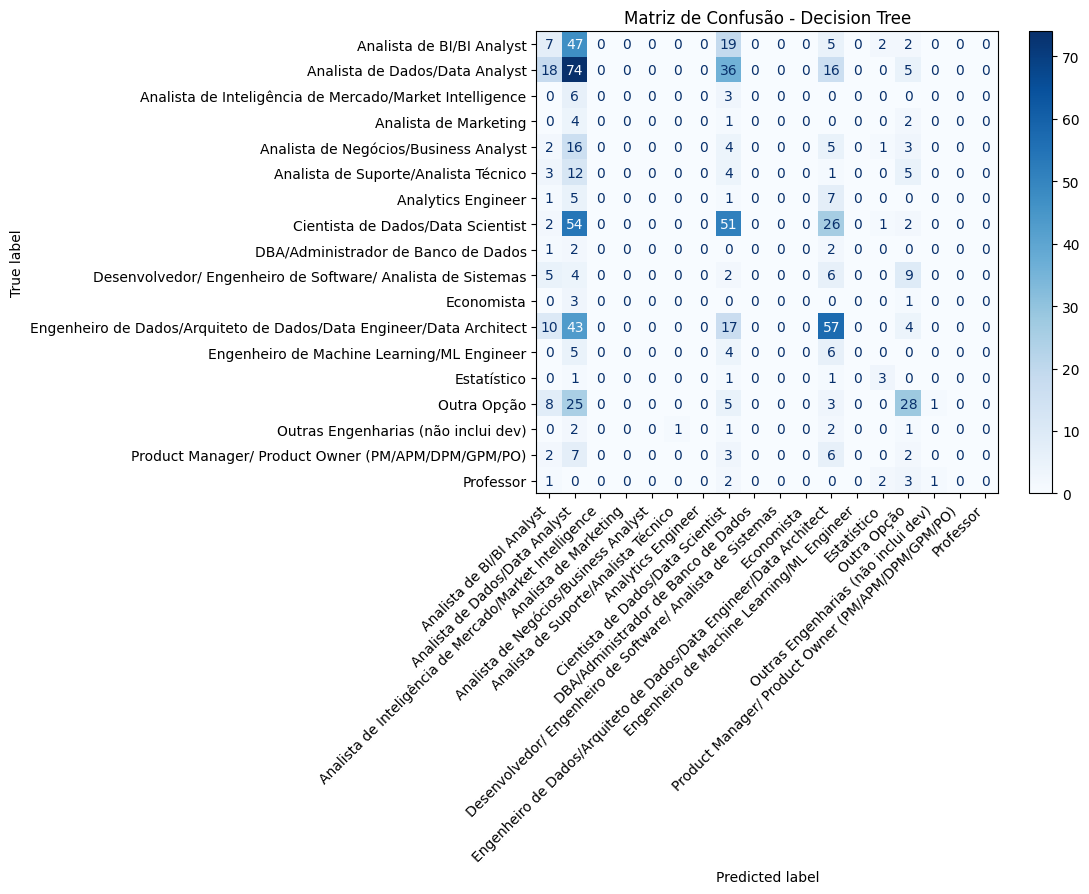


=== XGBoost ===
Accuracy : 0.3485254691689008
Precision: 0.3098888941059464
F1-Score : 0.31684868242734177

Classification Report:
                                                                      precision    recall  f1-score   support

                                          Analista de BI/BI Analyst       0.24      0.26      0.25        82
                                     Analista de Dados/Data Analyst       0.31      0.54      0.39       149
            Analista de Inteligência de Mercado/Market Intelligence       0.00      0.00      0.00         9
                                              Analista de Marketing       0.00      0.00      0.00         7
                              Analista de Negócios/Business Analyst       0.00      0.00      0.00        31
                               Analista de Suporte/Analista Técnico       0.25      0.04      0.07        25
                                                 Analytics Engineer       0.00      0.00      0.00     

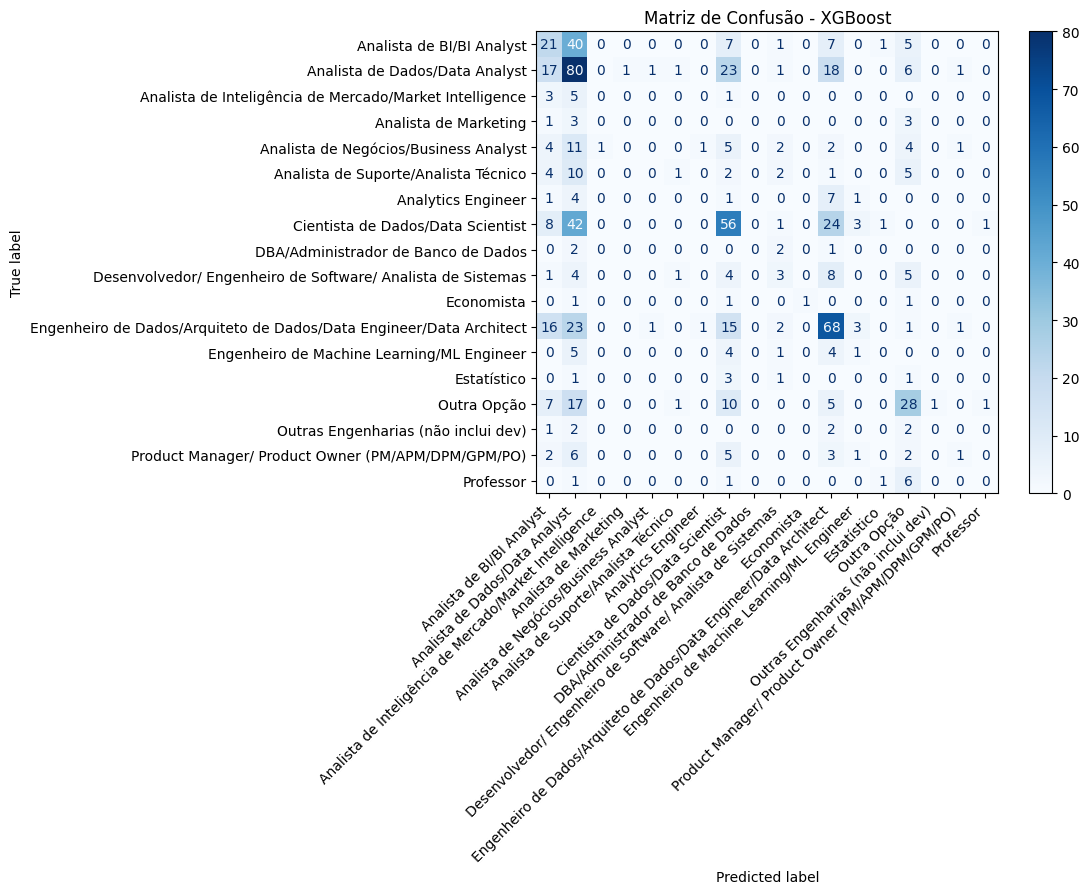

In [29]:
confusion_matrices = evaluate_models(
    models=[
        ("Decision Tree", initial_tree_pipeline), 
        ("XGBoost", initial_xgb_pipeline)
    ],
    dataset=initial_evaluate_dataset,
    test_size=0.25,
    RANDOM_STATE=RANDOM_STATE
)

### Análise de Correlação entre os Rótulos e Clusterizando

Fizemos dois tipos de cluster com relação as classes preditas, um por proximidade euclidiana e, outra pelo quão confudidas as classes são entre si pelo modelo.

In [30]:
# Cluster por Proximidade
cargo_map_by_proximity = group_by_proximity(
    dataset=initial_evaluate_dataset,
    target=target, 
    number_of_clusters=5,
    preprocessor=initial_preprocessor
)

Cluster 1: ['Analista de BI/BI Analyst', 'Analista de Marketing', 'Analista de Negócios/Business Analyst', 'Analista de Suporte/Analista Técnico', 'Analytics Engineer', 'DBA/Administrador de Banco de Dados', 'Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas', 'Economista', 'Engenheiro de Machine Learning/ML Engineer', 'Estatístico', 'Outra Opção', 'Outras Engenharias (não inclui dev)', 'Product Manager/ Product Owner (PM/APM/DPM/GPM/PO)', 'Professor']
Cluster 4: ['Analista de Dados/Data Analyst']
Cluster 2: ['Analista de Inteligência de Mercado/Market Intelligence']
Cluster 5: ['Cientista de Dados/Data Scientist']
Cluster 3: ['Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect']


In [31]:
# Cluster por Confusão
cargo_map_by_confusion = group_by_confusion(confusion_matriz_dict=confusion_matrices["XGBoost"], 
                   number_of_clusters=5
                  )

Cluster 4: ['Analista de BI/BI Analyst', 'Analista de Inteligência de Mercado/Market Intelligence', 'Analista de Marketing', 'Analista de Negócios/Business Analyst', 'Analista de Suporte/Analista Técnico', 'Analytics Engineer', 'DBA/Administrador de Banco de Dados', 'Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas', 'Economista', 'Engenheiro de Machine Learning/ML Engineer', 'Estatístico', 'Outras Engenharias (não inclui dev)', 'Product Manager/ Product Owner (PM/APM/DPM/GPM/PO)', 'Professor']
Cluster 3: ['Analista de Dados/Data Analyst']
Cluster 1: ['Cientista de Dados/Data Scientist']
Cluster 2: ['Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect']
Cluster 5: ['Outra Opção']


### Agrupamento Semântico dos Rótulos
Como foi apresentado na visualização, a coluna cargo estava desbalanceada, para corrigir isso, foi realizado o agrupamento das classes.

Para os v1 até v4, foi utilizada a técnica de clusterização nos rótulos por distância euclidiana e, ajustando posteriormente os clusters.

Para os v5 até v8, foi utilizada a técnica de clusterização nos rótulos por distância confusão e, ajustando posteriormente os clusters.

In [32]:
# Fica por volta dos 0.4 de acurácia e de F1-Score
cargo_map_v1 = {
    # Funções orientadas a análise exploratória, relatórios e apoio a decisão
    'Analista de Dados/Data Analyst': 'Analista Dados ou Insights',
    'Estatístico': 'Analista Dados ou Insights',
    'Economista': 'Analista Dados ou Insights',

    # Funções ligadas a modelagem, estatística e pesquisa aplicada
    'Cientista de Dados/Data Scientist': 'Cientista de Dados ou Modelagem',
    'Engenheiro de Machine Learning/ML Engineer': 'Cientista de Dados ou Modelagem',
    'Professor':'Cientista de Dados ou Modelagem',

    # Foco em infraestrutura, pipelines, banco de dados
    'Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect': 'Engenharia de Dados ou Plataformas',
    'Analytics Engineer': 'Engenharia de Dados ou Plataformas',
    'Outras Engenharias (não inclui dev)': 'Engenharia de Dados ou Plataformas',
    'DBA/Administrador de Banco de Dados': 'Engenharia de Dados ou Plataformas',
    'Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas': 'Engenharia de Dados ou Plataformas',

    # Voltado a dashboards, ETL leve e suporte ao negócio
    'Analista de BI/BI Analyst': 'Bi ou Operações de Sistemas',
    'Analista de Negócios/Business Analyst': 'Bi ou Operações de Sistemas',
    'Analista de Inteligência de Mercado/Market Intelligence': 'Bi ou Operações de Sistemas',
    'Analista de Marketing': 'Bi ou Operações de Sistemas',
    'Analista de Suporte/Analista Técnico': 'Bi ou Operações de Sistemas',
    'Product Manager/ Product Owner (PM/APM/DPM/GPM/PO)': 'Bi ou Operações de Sistemas',

    # Para evitar chutes sobre o que são essas funções
    'Outra Opção': 'Outra Opção'
}

# Fica por volta dos 0.45 de acurácia e de 0.40 para F1-Score
cargo_map_v2 = {
    # Funções orientadas a análise exploratória, relatórios e apoio a decisão
    'Estatístico': 'Insights',
    'DBA/Administrador de Banco de Dados': 'Insights',
    'Analista de Marketing': 'Insights',

    # Funções ligadas a modelagem, estatística e pesquisa aplicada
    'Cientista de Dados/Data Scientist': 'Cientista de Dados e Modelagem',
    'Analista de BI/BI Analyst': 'Cientista de Dados e Modelagem',


    'Outras Engenharias (não inclui dev)': 'Pesquisa',
    'Professor':'Pesquisa',

    # Foco em infraestrutura, pipelines, banco de dados
    'Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect': 'Analista Dados e Insights',
    'Analista de Dados/Data Analyst': 'Analista Dados e Insights',


    'Analytics Engineer': 'Analise do Mercado',
    'Analista de Negócios/Business Analyst': 'Analise do Mercado',

    'Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas': 'Desenvolvimento de Sistemas e Modelos',
    'Engenheiro de Machine Learning/ML Engineer': 'Desenvolvimento de Sistemas e Modelos',
    'Outra Opção': 'Desenvolvimento de Sistemas e Modelos',
}

# Fica por volta dos 0.7 de acurácia e de 0.6 para F1-Score
cargo_map_v3 = {
    # Funções orientadas a análise exploratória, relatórios e apoio a decisão
    'Estatístico': 'Pesquisa',
    'DBA/Administrador de Banco de Dados': 'Pesquisa',
    'Analista de Marketing': 'Pesquisa',
    'Outras Engenharias (não inclui dev)': 'Pesquisa',
    'Professor':'Pesquisa',

    # Funções ligadas a modelagem, estatística e pesquisa aplicada
    'Cientista de Dados/Data Scientist': 'Cientista de Dados e Modelagem',
    'Analista de BI/BI Analyst': 'Cientista de Dados e Modelagem',
    'Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect': 'Cientista de Dados e Modelagem',
    'Analista de Dados/Data Analyst': 'Cientista de Dados e Modelagem',


    'Analytics Engineer': 'Analise do Mercado',
    'Analista de Negócios/Business Analyst': 'Analise do Mercado',

    'Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas': 'Analise do Mercado',
    'Engenheiro de Machine Learning/ML Engineer': 'Analise do Mercado',
    'Outra Opção': 'Analise do Mercado',
    'Analista de Suporte/Analista Técnico': 'Analise do Mercado',
    'Product Manager/ Product Owner (PM/APM/DPM/GPM/PO)': 'Analise do Mercado',
}

# Fica por volta dos 0.5 de acurácia e de 0.5 para F1-Score
cargo_map_v4 = {
    # Funções orientadas a análise exploratória, relatórios e apoio a decisão
    'Estatístico': 'Pesquisa',
    'DBA/Administrador de Banco de Dados': 'Pesquisa',
    'Analista de Marketing': 'Pesquisa',
    'Outras Engenharias (não inclui dev)': 'Pesquisa',
    'Professor':'Pesquisa',
    'Analytics Engineer': 'Pesquisa',
    'Analista de Negócios/Business Analyst': 'Pesquisa',

    'Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas': 'Pesquisa',
    'Engenheiro de Machine Learning/ML Engineer': 'Pesquisa',
    'Outra Opção': 'Pesquisa',
    'Analista de Suporte/Analista Técnico': 'Pesquisa',
    'Product Manager/ Product Owner (PM/APM/DPM/GPM/PO)': 'Pesquisa',


    # # Funções ligadas a modelagem, estatística e pesquisa aplicada
    'Cientista de Dados/Data Scientist': 'Cientista de Dados e Modelagem',
    'Analista de BI/BI Analyst': 'Cientista de Dados e Modelagem',

    'Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect': 'Dados_Insights',
    'Analista de Dados/Data Analyst': 'Dados_Insights',


    # Voltado a dashboards, ETL leve e suporte ao negócio
    'Analista de Inteligência de Mercado/Market Intelligence': 'Cientista de Dados e Modelagem',
    'Economista': 'Cientista de Dados e Modelagem'
}

cargo_map_v5 = {
    # Analistas de Dados / BI
    'Analista de Dados/Data Analyst': 'Analista de Dados/BI',
    'Analista de BI/BI Analyst': 'Analista de Dados/BI',

    # Data Science & Engenharia
    'Cientista de Dados/Data Scientist': 'Data Science & Engenharia',
    'Engenheiro de Machine Learning/ML Engineer': 'Data Science & Engenharia',
    'Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect': 'Data Science & Engenharia',
    'Analytics Engineer': 'Data Science & Engenharia',

    # Negócios / Marketing / Suporte
    'Analista de Negócios/Business Analyst': 'Analistas Negócio/Marketing',
    'Analista de Inteligência de Mercado/Market Intelligence': 'Analistas Negócio/Marketing',
    'Analista de Marketing': 'Analistas Negócio/Marketing',
    'Analista de Suporte/Analista Técnico': 'Analistas Negócio/Marketing',
    'Product Manager/ Product Owner (PM/APM/DPM/GPM/PO)': 'Analistas Negócio/Marketing',

    # DBA & Desenvolvimento
    'DBA/Administrador de Banco de Dados': 'DBA/Dev',
    'Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas': 'DBA/Dev',

    # Outros
    'Economista': 'Outros',
    'Professor': 'Outros',
    'Estatístico': 'Outros',
    'Outras Engenharias (não inclui dev)': 'Outros',

    # Mantém separado
    'Outra Opção': 'Outra Opção'
}

cargo_map_v6 = {
    # Dados (Analistas, Cientistas e Engenheiros)
    'Analista de Dados/Data Analyst': 'Dados',
    'Analista de BI/BI Analyst': 'Dados',
    'Cientista de Dados/Data Scientist': 'Dados',
    'Engenheiro de Machine Learning/ML Engineer': 'Dados',
    'Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect': 'Dados',
    'Analytics Engineer': 'Dados',

    # Negócio & Produto
    'Analista de Negócios/Business Analyst': 'Negócio/Produto',
    'Analista de Inteligência de Mercado/Market Intelligence': 'Negócio/Produto',
    'Analista de Marketing': 'Negócio/Produto',
    'Analista de Suporte/Analista Técnico': 'Negócio/Produto',
    'Product Manager/ Product Owner (PM/APM/DPM/GPM/PO)': 'Negócio/Produto',

    # Desenvolvimento & Bancos de Dados
    'DBA/Administrador de Banco de Dados': 'Dev & Bancos',
    'Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas': 'Dev & Bancos',

    # Outros
    'Economista': 'Outros',
    'Professor': 'Outros',
    'Estatístico': 'Outros',
    'Outras Engenharias (não inclui dev)': 'Outros',
    'Outra Opção': 'Outros'
}

cargo_map_v7 = {
    # Dados (Analistas, Cientistas e Engenheiros)
    'Analista de Dados/Data Analyst': 'Dados',
    'Analista de BI/BI Analyst': 'Dados',
    'Cientista de Dados/Data Scientist': 'Dados',
    'Engenheiro de Machine Learning/ML Engineer': 'Dados',
    'Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect': 'Dados',
    'Analytics Engineer': 'Dados',

    # Outros
    'Analista de Negócios/Business Analyst': 'Outros',
    'Analista de Inteligência de Mercado/Market Intelligence': 'Outros',
    'Analista de Marketing': 'Outros',
    'Analista de Suporte/Analista Técnico': 'Outros',
    'Product Manager/ Product Owner (PM/APM/DPM/GPM/PO)': 'Outros',
    'DBA/Administrador de Banco de Dados': 'Outros',
    'Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas': 'Outros',
    'Economista': 'Outros',
    'Professor': 'Outros',
    'Estatístico': 'Outros',
    'Outras Engenharias (não inclui dev)': 'Outros',
    'Outra Opção': 'Outros'
}


# cargo_map_vN = {
#     'Analista de Dados/Data Analyst': ,
#     'Estatístico': ,
#     'Economista': ,

#     'Cientista de Dados/Data Scientist': ,
#     'Engenheiro de Machine Learning/ML Engineer': ,
#     'Professor':,

#     'Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect': ,
#     'Analytics Engineer': ,
#     'Outras Engenharias (não inclui dev)': ,
#     'DBA/Administrador de Banco de Dados': ,
#     'Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas': ,

#     # Voltado a dashboards, ETL leve e suporte ao negócio
#     'Analista de BI/BI Analyst': ,
#     'Analista de Negócios/Business Analyst': ,
#     'Analista de Inteligência de Mercado/Market Intelligence': ,
#     'Analista de Marketing': ,
#     'Analista de Suporte/Analista Técnico': ,
#     'Product Manager/ Product Owner (PM/APM/DPM/GPM/PO)': ,

#     # Para evitar chutes sobre o que são essas funções
#     'Outra Opção': 'Outra Opção'
# }

In [44]:
cargo_map = cargo_map_v3 # cargo_map_v3 | cargo_map_by_proximity | cargo_map_by_confusion

dataset_isoleted_BDs_remap = apply_map(dataset_isoleted_BDs, target, cargo_map)
dataset_cut_remap = apply_map(dataset_cut, target, cargo_map)

In [45]:
dataset_isoleted_BDs[target].value_counts()

cargo
Analista de Dados/Data Analyst                                         639
Cientista de Dados/Data Scientist                                      556
Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect    490
Analista de BI/BI Analyst                                              378
Outra Opção                                                            281
Analista de Negócios/Business Analyst                                  123
Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas            106
Analista de Suporte/Analista Técnico                                    72
Analytics Engineer                                                      70
Engenheiro de Machine Learning/ML Engineer                              69
Product Manager/ Product Owner (PM/APM/DPM/GPM/PO)                      51
Analista de Inteligência de Mercado/Market Intelligence                 29
Outras Engenharias (não inclui dev)                                     28
Professor          

In [46]:
dataset_isoleted_BDs_remap[target].value_counts()

cargo
Cientista de Dados e Modelagem                             2063
Analise do Mercado                                          772
Pesquisa                                                    101
Analista de Inteligência de Mercado/Market Intelligence      29
Economista                                                   16
Name: count, dtype: int64

### Visualização final da Associação

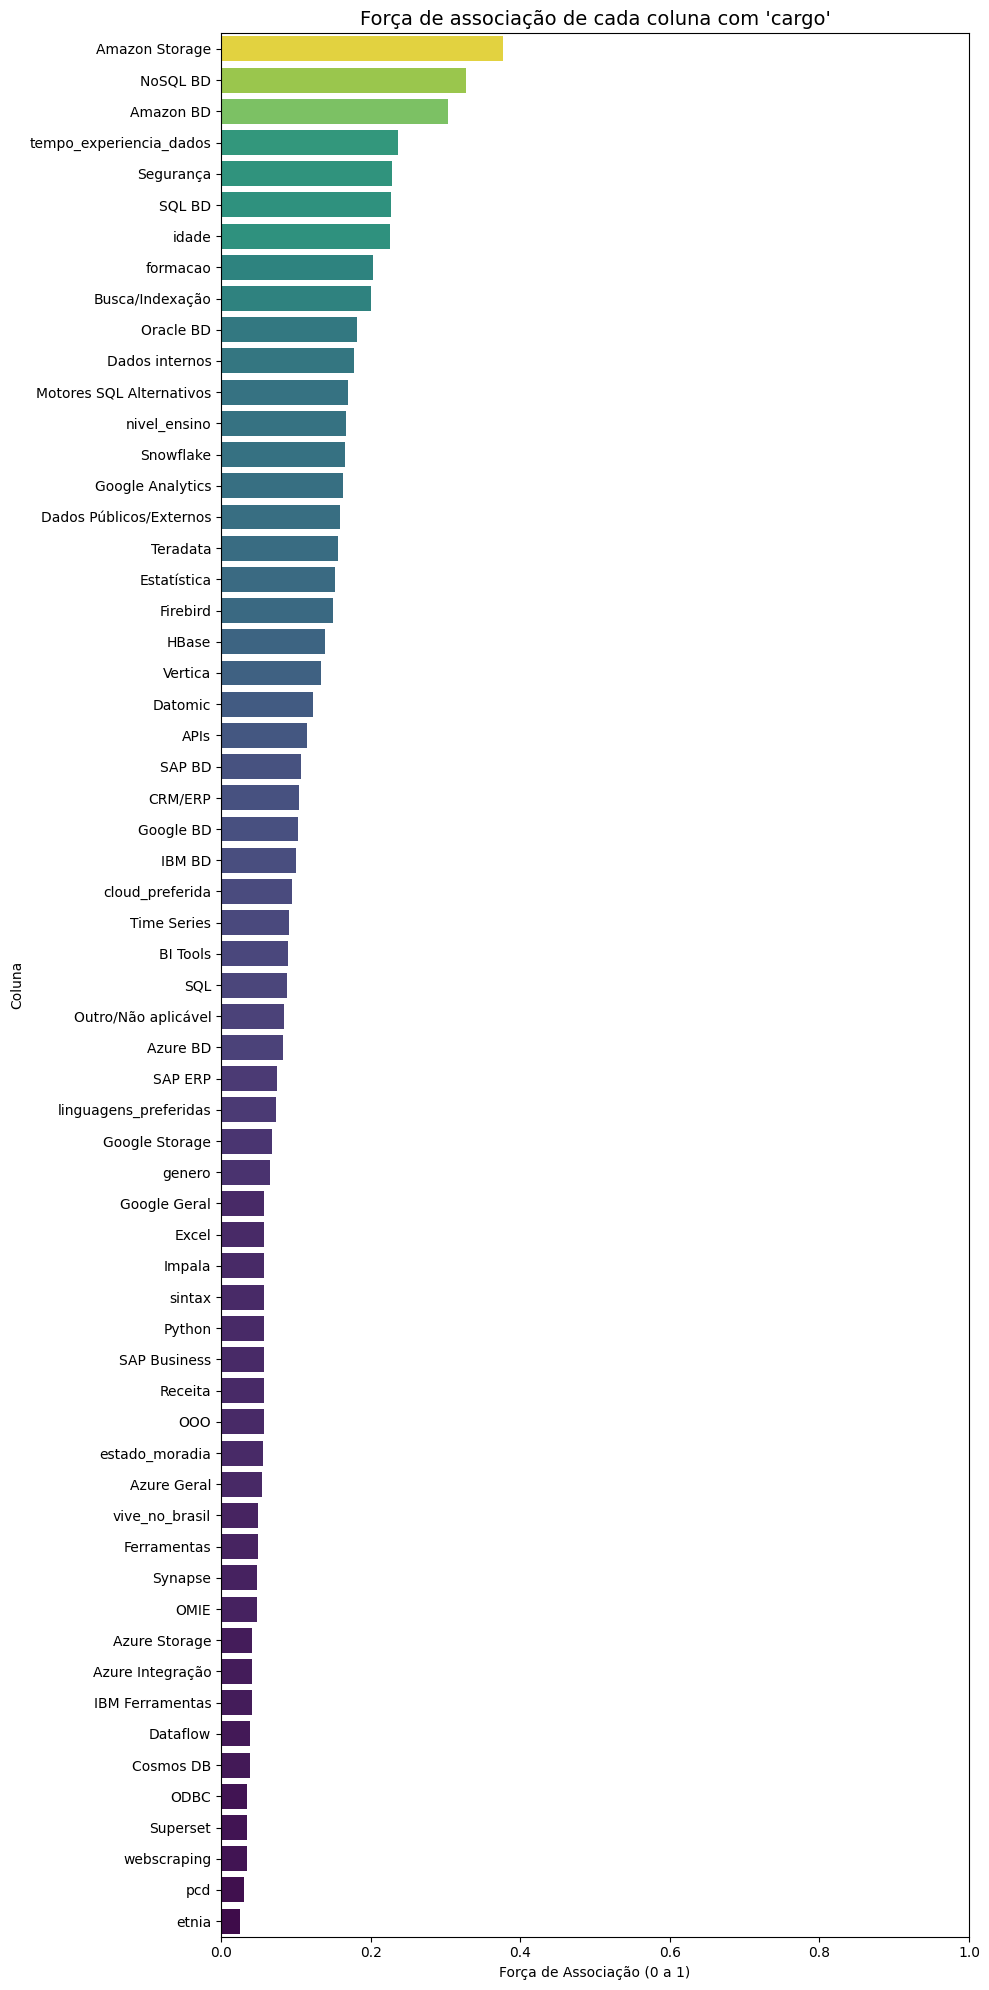

In [47]:
calculate_association_strength(dataset_isoleted_BDs, target, (10, 20))

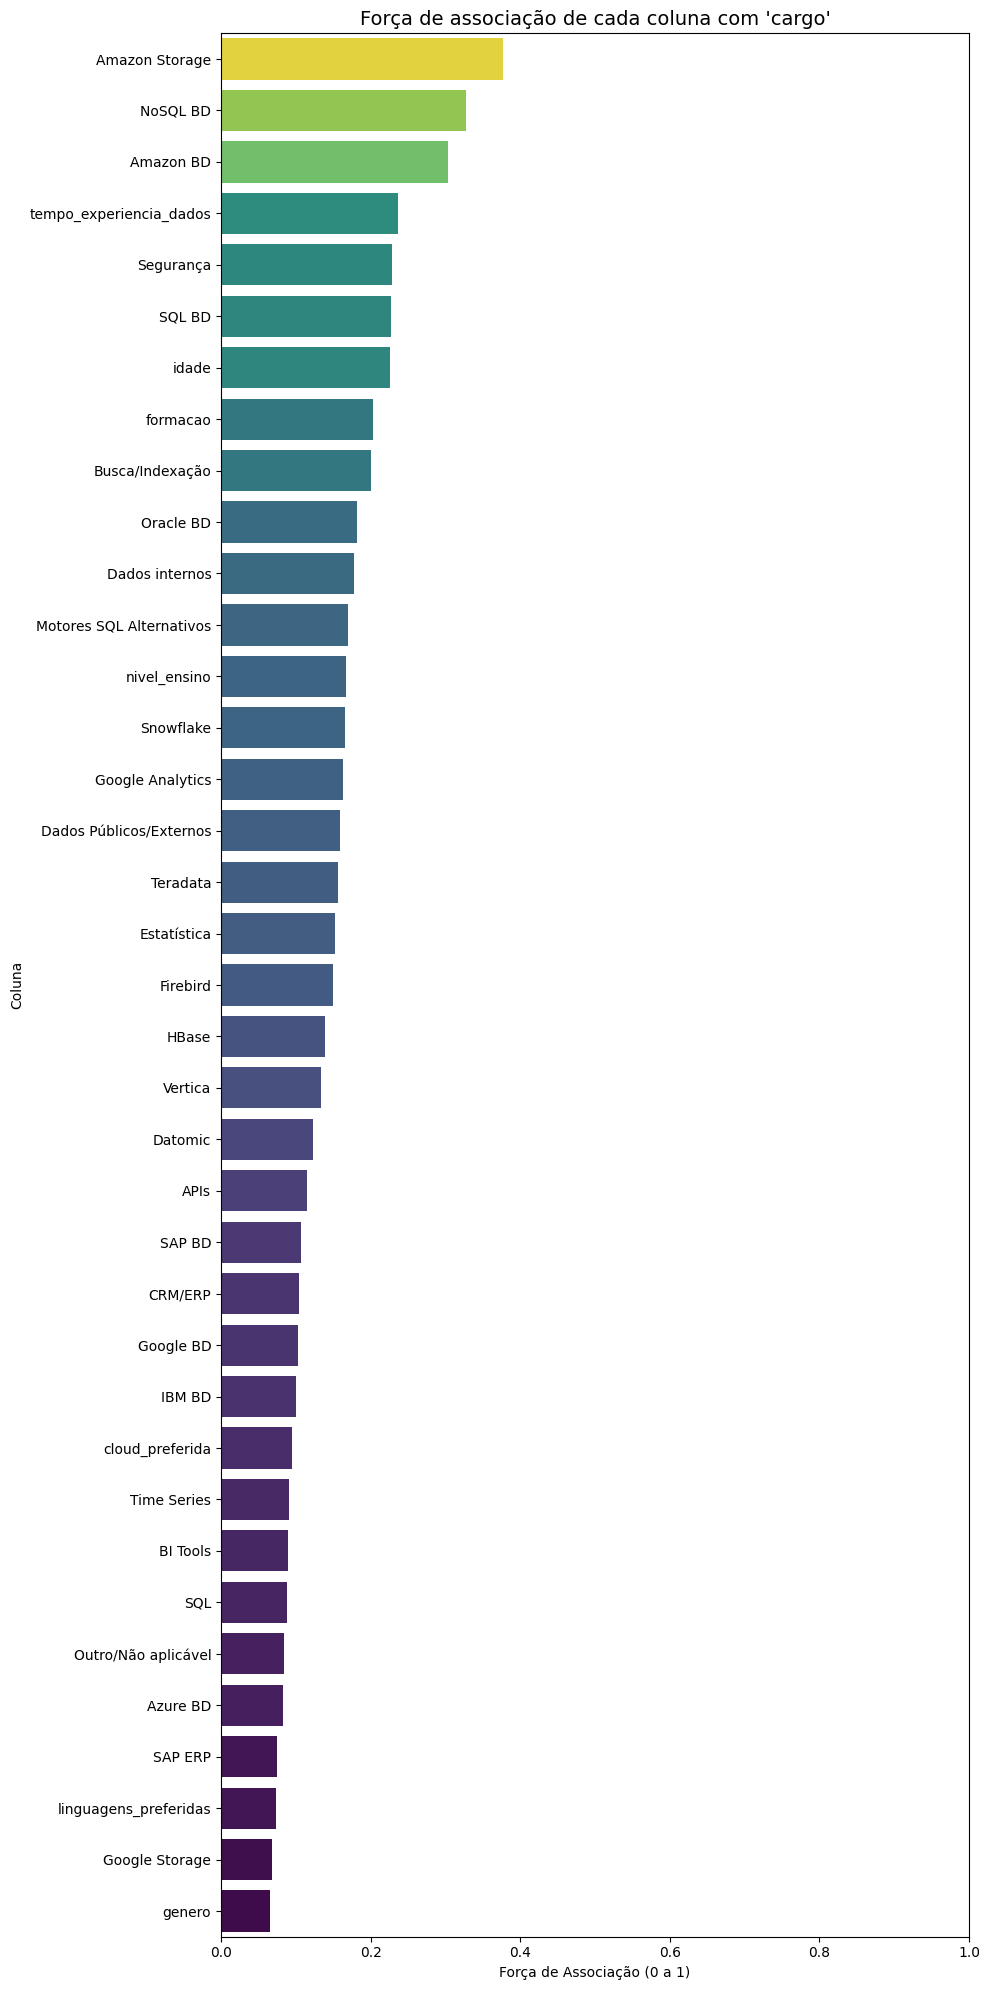

In [48]:
calculate_association_strength(dataset_cut, target, (10, 20))

### Tratamento dos Dados
Tratamento por pipeline dos dados, antes de envia-los para o modelo.

Foram estabelecidos três tipos diferentes de tratamentos:
- Por regressão e normalização, para dados númericos.
- Por moda e classificando tudo para 0 e 1, para dados binarios.
- Por moda e dividindo as tabelas em binarias, para dados categoricos.

In [49]:
types = classifier_columns(dataset_isoleted_BDs.drop(columns=[target]))

In [50]:
types.keys()

dict_keys(['numeric', 'binary', 'categoric'])

In [51]:
types["categoric"]

['genero',
 'etnia',
 'pcd',
 'estado_moradia',
 'nivel_ensino',
 'formacao',
 'tempo_experiencia_dados',
 'linguagens_preferidas',
 'cloud_preferida']

In [52]:
numeric_transformer = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5)), # Preenche os valores ausentes, atráves dos n vizinhos mais próximos.
    ("scaler", StandardScaler()) # Normaliza, média 0 e desvio padrão 1.
])

binary_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")), # Preenche os valores ausentes, com a moda.
    ("encoder", OneHotEncoder(handle_unknown="ignore")) # Torna as colunas categoricas em binarias. Caso seja true e false, passa pra 0 e 1.
])

categoric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")), # Preenche os valores ausentes, com a moda.
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)) # Passa pra 0 e 1.
])

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, types["numeric"]),
        ("binary", binary_transformer, types["binary"]),
        ("categoric", categoric_transformer, types["categoric"])
    ]
)

# Treinamento e Avaliação dos Modelos

### Estrutura dos Modelos

Foram utilizados os modelos de árvore de decisão e, de XGboost, testamos também modelos de Rede Neural, porém o ganho de desempenho não foi o suficiente.

O ajuste de hiperparâmetros foi realizado atráves de testes manuais, alterando e avaliando o desempenho, para cada parâmetro, comecei com valores baixos e fui elevando, até estagnar o aumento de desempenho, além disso, testei para várias combinações diferentes de hiperparâmetros e fui avaliando, até chegar nos atuais.

In [53]:
# Decision Tree
tree_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(
        max_depth=6,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=RANDOM_STATE
    ))
])

# XGBoost
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        n_estimators=170,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        eval_metric="mlogloss"
    ))
])

### Avaliação dos Modelos

Avaliando métricas como:
- Acuracia, para verificar o quanto o modelo acerta.
- Precisão, para ver o quanto o modelo erra.
- F1-Score, para ver se o modelo não está "chutando" as respostas.

Os melhores resultados foram com o cargo_map_v3, chegando em 0.7 de acurácia e de 0.6 para F1-Score.


=== Decision Tree ===
Accuracy : 0.7217877094972067
Precision: 0.6908929221696228
F1-Score : 0.6553681915386467

Classification Report:
                                                          precision    recall  f1-score   support

                                     Analise do Mercado       0.69      0.22      0.33       235
Analista de Inteligência de Mercado/Market Intelligence       0.00      0.00      0.00        10
                         Cientista de Dados e Modelagem       0.73      0.98      0.83       606
                                             Economista       0.00      0.00      0.00         4
                                               Pesquisa       0.40      0.05      0.09        40

                                               accuracy                           0.72       895
                                              macro avg       0.36      0.25      0.25       895
                                           weighted avg       0.69      0.72      0.

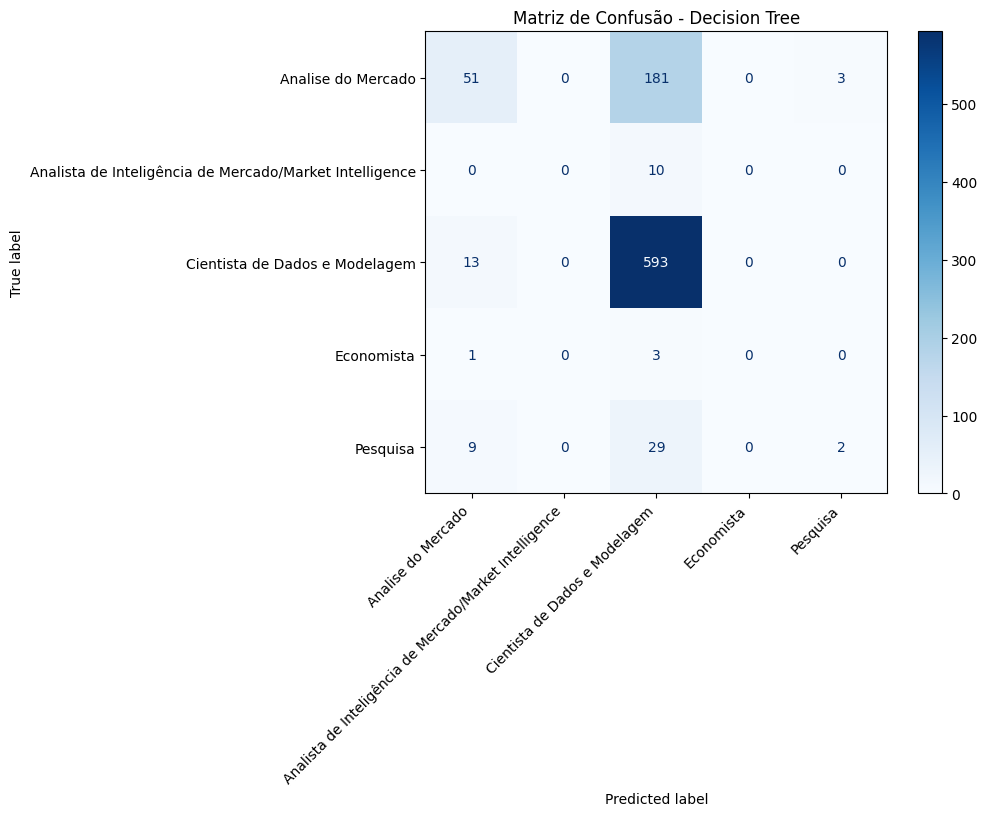


=== XGBoost ===
Accuracy : 0.7139664804469273
Precision: 0.6549060401148211
F1-Score : 0.657030458070701

Classification Report:
                                                          precision    recall  f1-score   support

                                     Analise do Mercado       0.61      0.27      0.37       235
Analista de Inteligência de Mercado/Market Intelligence       0.00      0.00      0.00        10
                         Cientista de Dados e Modelagem       0.73      0.95      0.83       606
                                             Economista       0.00      0.00      0.00         4
                                               Pesquisa       0.00      0.00      0.00        40

                                               accuracy                           0.71       895
                                              macro avg       0.27      0.24      0.24       895
                                           weighted avg       0.65      0.71      0.66     

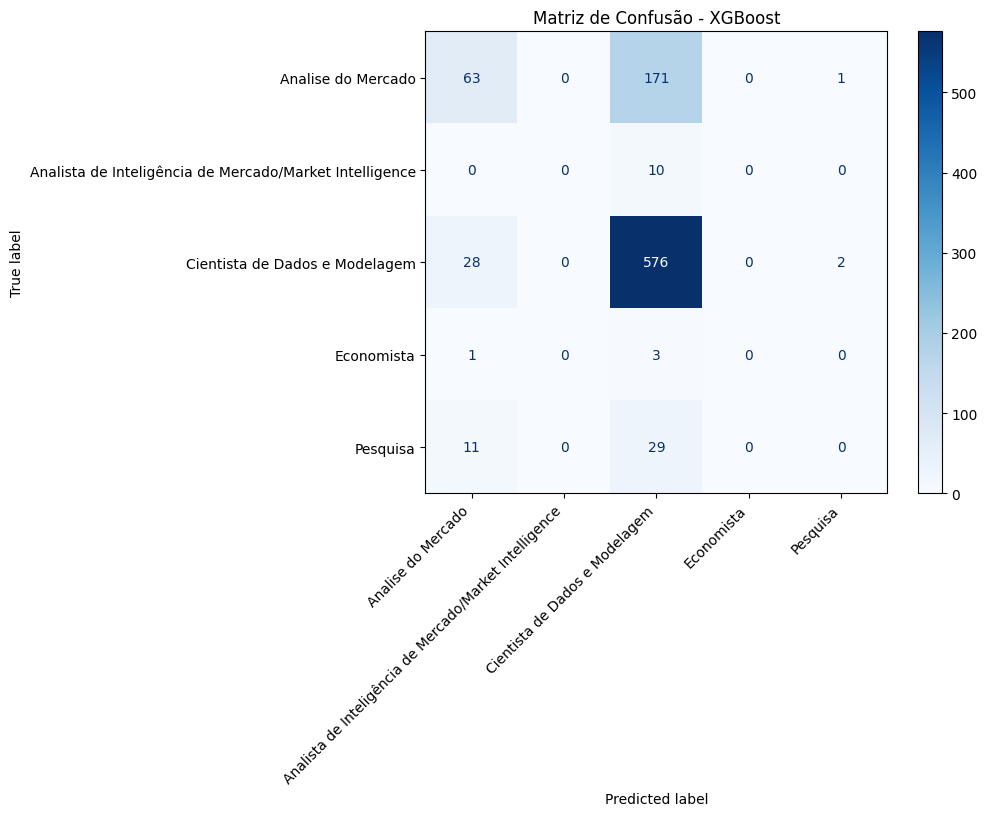

In [54]:
final_confusion_matrices = evaluate_models(
    models=[
        ("Decision Tree", tree_pipeline),
        ("XGBoost", xgb_pipeline)
    ],
    dataset=dataset_isoleted_BDs_remap,
    test_size=0.3,
    RANDOM_STATE=RANDOM_STATE
)